## Intro

The main idea behind this notebook is to do some web scraping and pull together all the ratings for the latest and greatest phones for Pixel, iPhone, and Samsung and try and get a quick feel for the over all ratings for the phones.

This is all because I need to get a new phone soon as mine has gone sour.

### Scrape Google Search Results

http://edmundmartin.com/scraping-google-with-python/

I used the above reference to try and build out a way collect all the reviews.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import time
import requests
from bs4 import BeautifulSoup

In [10]:
USER_AGENT = {'User-Agent':'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/61.0.3163.100 Safari/537.36'}

headers = requests.utils.default_headers()
headers.update({
    'User-Agent': 'Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:52.0) Gecko/20100101 Firefox/52.0',
})

I ran into some trouble when I was testing out the code where my ip got temporarily flagged as a bot or something. I used the built in error and some googling to come up with that. Luckily, as I said, it was only temporary.

In [11]:
def fetch_results(search_term, number_results, language_code):
    assert isinstance(search_term, str), 'Search term must be a string'
    assert isinstance(number_results, int), 'Number of results must be an integer'
    escaped_search_term = search_term.replace(' ', '+')
 
    google_url = 'https://www.google.com/search?q={}&num={}&hl={}'.format(escaped_search_term, number_results, language_code)
    response = requests.get(google_url, headers=USER_AGENT)
    response.raise_for_status()
 
    return search_term, response.text

def parse_results(html, keyword):
    soup = BeautifulSoup(html, 'html.parser')

    found_results = []
    rank = 1
    result_block = soup.find_all('div', attrs={'class': 'g'})
    for result in result_block:

        link = result.find('a', href=True)
        title = result.find('h3', attrs={'class': 'r'})
        description = result.find('span', attrs={'class': 'st'})
        if link and title:
            link = link['href']
            title = title.get_text()
            if description:
                description = description.get_text()
            if link != '#':
                found_results.append({'keyword': keyword, 'rank': rank, 'title': title, 'description': description})
                rank += 1
    return found_results

def scrape_google(search_term, number_results, language_code):
    try:
        keyword, html = fetch_results(search_term, number_results, language_code)
        results = parse_results(html, keyword)
        return results
    except AssertionError:
        raise Exception("Incorrect arguments parsed to function")
    except requests.HTTPError:
        raise Exception("You appear to have been blocked by Google")
    except requests.RequestException:
        raise Exception("Appears to be an issue with your connection")

The definitions above were from the reference and what I did in starting to test this out was just changing the keyword. I realized though that it was going to take further digging into the html to get what I wanted.

In [12]:
keywords = ['pixel 2 xl rating'] #['edmund martin', 'python', 'google scraping']
data = []
for keyword in keywords:
    try:
        results = scrape_google(keyword, 1, "en")
        for result in results:
            data.append(result)
    except Exception as e:
        print(e)
    finally:
        time.sleep(10)
print(data)

[{'description': 'May 9, 2018 - Despite losing the cherished 3.5mm headphone jack, the Pixel 2 XL makes up for it in spades with a mix of unique and sought-after features\xa0...', 'keyword': 'pixel 2 xl rating', 'title': 'Google Pixel 2 XL review | TechRadar', 'rank': 1}]


In [13]:
data[0]['description']

'May 9, 2018 - Despite losing the cherished 3.5mm headphone jack, the Pixel 2 XL makes up for it in spades with a mix of unique and sought-after features\xa0...'

So we can pull that description out like a dictionary. 

I was having some trouble using the Beautiful Soup features of finding anything related to "Rating" so I did a small search and pulled that html out and into a text file where I control-F searched it and found the tags related to my "Ratings" were :

__g-review-stars__

In [14]:
# keyword, html = fetch_results('pixel 2 xl ratings', 100, 'en')
keyword, html = fetch_results('iphone 7 ratings', 1, 'en')
# print(html)

In [15]:
soup = BeautifulSoup(html, 'html.parser')
len(soup.find_all('g-review-stars'))

4

In [16]:
soup.find_all('g-review-stars')

[<g-review-stars><span aria-label="Rated 4.0 out of 5," class="tPhRLe"><span style="width:53px"></span></span></g-review-stars>,
 <g-review-stars><span aria-label="Rated 4.5 out of 5," class="tPhRLe"><span style="width:59px"></span></span></g-review-stars>,
 <g-review-stars><span aria-label="Rated 4.6 out of 5," class="tPhRLe"><span style="width:59px"></span></span></g-review-stars>,
 <g-review-stars><span aria-label="Rated 4.6 out of 5," class="tPhRLe"><span style="width:59px"></span></span></g-review-stars>]

Not every phone I searched about had the same number of reviews so I had to figure out a way to hold a minimum, additionally there are some cases where a _Rating_ appeared multiple times with in the html, sometimes the same, sometimes different. I left all instances in here for simplicity's sake however I should dig further into this to see what all it is pulling.

Additionally, some of the searches could end up having multiple phone reviews in the links. It appears that __g-review-stars__ meant google review stars which leads me to think each review is for one phone but perhaps multiple features in the phone. So technically even keeping all of the reviews in should be alright.

In [17]:
## reformatted parse results function to calculate my over all ratings and throw them into a list
def parse_res(html, keyword):
    soup = BeautifulSoup(html, 'html.parser')
    
    ratings = soup.find_all('g-review-stars')
    rat_vals = []
    
    for r in ratings:
        snum = str(r).split('Rated ')[1][:3]
        sden = str(r).split('Rated ')[1].split(' out of ')[1][0]

        num, den = float(snum), float(sden)

#         print(num/den)
        rat_vals.append(num/den)
    return rat_vals

In [18]:
## picked a few phones
keywords = ['pixel 2 xl ratings','iphone 8 ratings','iphone x ratings', 'samsung galaxy s8 ratings']

## This portion aggregates all the data and determines the min number of ratings
data = []
min_rates = 30
for k in keywords:
    keyw, html = fetch_results(k, 100, 'en')
    ratings = parse_res(html, keyw)
    
    if len(ratings) < min_rates:
        min_rates = len(ratings)
        
    data.append(ratings)


Here are some summary stats of the data sets regardless of length.

In [19]:
dc = 0
for d in data:
    print(keywords[dc]+" : mean = {:.3f},  std = {:.3f},  len = {}".format(np.mean(d), np.std(d), len(d)))
    dc+=1

pixel 2 xl ratings : mean = 0.848,  std = 0.078,  len = 33
iphone 8 ratings : mean = 0.818,  std = 0.123,  len = 26
iphone x ratings : mean = 0.864,  std = 0.125,  len = 31
samsung galaxy s8 ratings : mean = 0.860,  std = 0.094,  len = 25


In [20]:
from scipy import stats as sps

In [21]:
print(keywords[0] + ' to ' + keywords[1])
print(sps.ttest_ind(data[0], data[1]),'\n')

print(keywords[0] + ' to ' + keywords[2])
print(sps.ttest_ind(data[0], data[2]),'\n')

print(keywords[0] + ' to ' + keywords[3])
print(sps.ttest_ind(data[0], data[3]),'\n')

print(keywords[1] + ' to ' + keywords[2])
print(sps.ttest_ind(data[1], data[2]),'\n')

print(keywords[1] + ' to ' + keywords[3])
print(sps.ttest_ind(data[1], data[3]),'\n')

print(keywords[2] + ' to ' + keywords[3])
print(sps.ttest_ind(data[2], data[3]),'\n')

pixel 2 xl ratings to iphone 8 ratings
Ttest_indResult(statistic=1.122724504300857, pvalue=0.2662614246107148) 

pixel 2 xl ratings to iphone x ratings
Ttest_indResult(statistic=-0.58516299669541, pvalue=0.5605618872761315) 

pixel 2 xl ratings to samsung galaxy s8 ratings
Ttest_indResult(statistic=-0.5000371034568548, pvalue=0.6190082635072088) 

iphone 8 ratings to iphone x ratings
Ttest_indResult(statistic=-1.3552891682894874, pvalue=0.18086546878313817) 

iphone 8 ratings to samsung galaxy s8 ratings
Ttest_indResult(statistic=-1.3287236603608163, pvalue=0.1900939622897355) 

iphone x ratings to samsung galaxy s8 ratings
Ttest_indResult(statistic=0.1262342860756757, pvalue=0.9000153165835421) 



Taking a look at the independent t-tests of the means of the data for alpha=0.05, we can accept the Null and the means were drawn from a population with the same distribution - so we can continue on in our comparisons.

Here I aggregated the data based on the min number of samples but didnt do anything to check the best or worst ratings, just the first N.

In [22]:
## changing the aggregated data to numpy and pandas 
data_array = np.zeros((len(keywords),min_rates))
dj = 0
for d in data:
    ic=0
    for i in d[:min_rates]:
        data_array[dj,ic] = i
        ic+=1
    dj+=1

In [23]:
ratings_df = pd.DataFrame(data_array.T, columns = keywords)

In [24]:
ratings_df.describe()

,pixel 2 xl ratings,iphone 8 ratings,iphone x ratings,samsung galaxy s8 ratings
count,25.000000,25.000000,25.000000,25.000000
mean,0.836000,0.813600,0.848000,0.860000
std,0.081035,0.124996,0.132665,0.095743
min,0.600000,0.500000,0.300000,0.600000
25%,0.800000,0.800000,0.800000,0.800000
50%,0.800000,0.800000,0.900000,0.900000
75%,0.900000,0.900000,0.900000,0.900000
max,1.000000,1.000000,1.000000,1.000000


In [25]:
import seaborn as sns

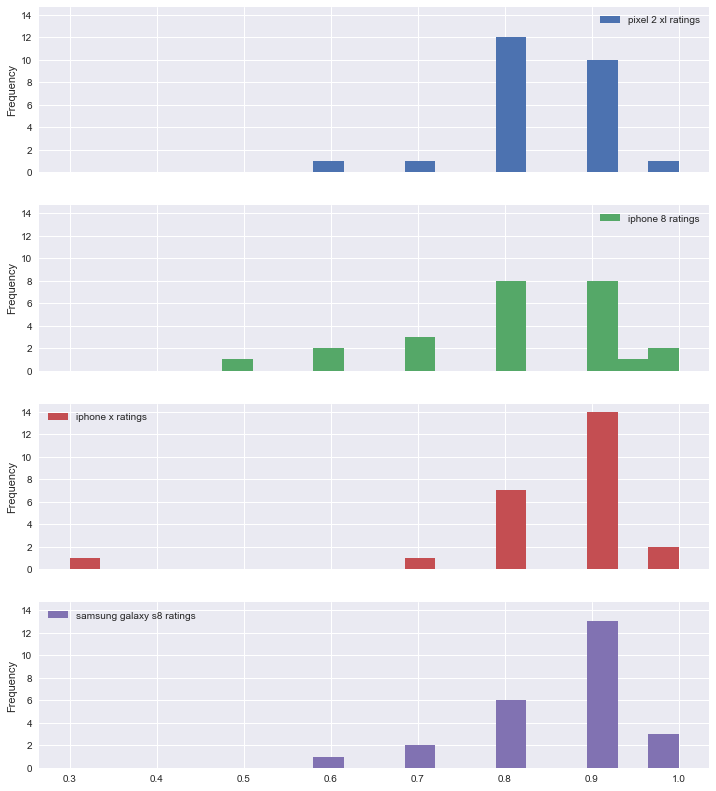

In [31]:
ratings_df.plot(kind='hist', bins=20, subplots=True, figsize=(12,14), sharey=True);

So here we can see the following highlights:

- The Pixel 2 XL has most counts falling in the 0.8 to 0.9 range.
- iPhone 8 has a more even distribution of ratings but a few throughout the 0.9 - 1.0 range.
- iPhone X has a significant count of ratings around 0.9 but also some really low ratings.
- The Samsung has the most even distribution for counts is probably the most reliabe from these reviews.
- The summary statistics relfect these findings and with the Pixel 2 XL and Samsung have low standard deviations indicating less variation in review.

